In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib

fileName = 'input/nn.csv'

dataFrame = pd.read_csv(
    fileName, 
    sep=";", 
    encoding='cp1251', 
    verbose=True, 
    keep_default_na=False
).dropna(how="all")

def check_float( x ):
    try:
        float(x)
    except ValueError:
        return False
    return True

dataFrame.drop_duplicates(subset=['price', 'total_square', 'number_of_rooms', 'longitude', 'latitude' ], keep='first', inplace=True)

#dataFrame = dataFrame[ dataFrame['price'    ].apply( check_float )]
dataFrame = dataFrame[ dataFrame['longitude'].apply( check_float )]
dataFrame = dataFrame[ dataFrame['latitude' ].apply( check_float )]
dataFrame.longitude = dataFrame.longitude.astype(np.float64)
dataFrame.latitude  = dataFrame.latitude .astype (np.float64)

print('Shape of the train data with all features:', dataFrame.shape)
dataFrame = dataFrame.select_dtypes(exclude=['object'])
dataFrame = dataFrame.astype(np.float64)
dataFrame = dataFrame.dropna(how="all")
print("")
print('Shape of the train data with numerical features:', dataFrame.shape)

print("")
print("List of features contained our dataset:",list(dataFrame.columns))
print( dataFrame.dtypes )
dataFrame.head(10)

Tokenization took: 25.91 ms
Type conversion took: 48.95 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 13.38 ms
Type conversion took: 39.57 ms
Parser memory cleanup took: 0.01 ms
Shape of the train data with all features: (63533, 11)

Shape of the train data with numerical features: (63533, 9)

List of features contained our dataset: ['price', 'longitude', 'latitude', 'total_square', 'living_square', 'kitchen_square', 'number_of_rooms', 'floor_number', 'number_of_floors']
price               float64
longitude           float64
latitude            float64
total_square        float64
living_square       float64
kitchen_square      float64
number_of_rooms     float64
floor_number        float64
number_of_floors    float64
dtype: object


,price,longitude,latitude,total_square,living_square,kitchen_square,number_of_rooms,floor_number,number_of_floors
0,2850000.0,44.075417,56.283864,43.0,14.0,11.0,1.0,9.0,17.0
1,8200000.0,43.942485,56.301539,98.5,52.0,14.0,3.0,3.0,17.0
2,2600000.0,43.923782,56.310448,64.0,42.0,6.0,4.0,2.0,5.0
3,2750000.0,44.064952,56.291499,50.0,30.0,9.0,2.0,3.0,5.0
4,2650000.0,43.957127,56.329128,45.0,31.0,6.0,2.0,2.0,5.0
5,2400000.0,44.023674,56.316345,76.0,44.0,12.0,2.0,6.0,9.0
6,3700000.0,43.996545,56.317807,45.0,37.0,6.5,2.0,2.0,8.0
7,3550000.0,44.079100,56.303541,41.8,18.6,11.3,1.0,9.0,9.0
8,5300000.0,43.999587,56.307397,70.5,0.0,0.0,2.0,4.0,22.0
9,1900000.0,44.001350,56.310740,57.0,27.0,12.0,1.0,6.0,12.0


Первичный анализ данных

Минимальные, максимальные и медианные величины
price                          min=       0.0, max=5990000000.0, median= 2760000.0
longitude                      min=       0.0, max=75.64584613, median= 43.930959
latitude                       min=       0.0, max= 61.588912, median= 56.297972
total_square                   min=       0.0, max=   60111.0, median=      46.0
living_square                  min=       0.0, max=    3062.4, median=      27.0
kitchen_square                 min=       0.0, max=     905.0, median=       8.0
number_of_rooms                min=       0.0, max=      30.0, median=       2.0
floor_number                   min=       0.0, max=     100.0, median=       4.0
number_of_floors               min=       0.0, max=     241.0, median=       9.0


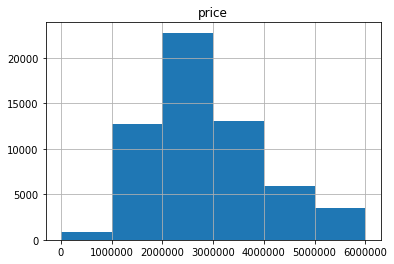

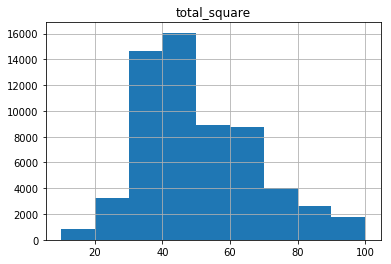

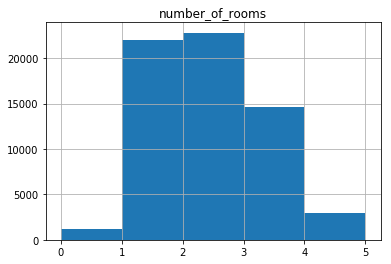

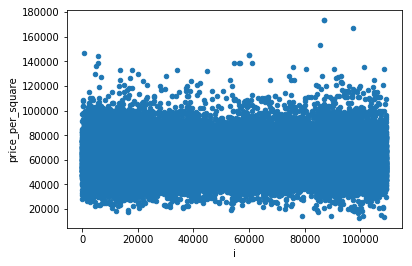

In [2]:
import matplotlib.pyplot as plt

print( "Минимальные, максимальные и медианные величины" )
for column in dataFrame:
    min_    = dataFrame[[column]].min   ().values[0]
    max_    = dataFrame[[column]].max   ().values[0]
    median_ = dataFrame[[column]].median().values[0]
    print( "{:30} min={:10}, max={:10}, median={:10}".format( column, min_, max_, median_ ) )

dataFrame[['price'          ]].hist( bins=[0.0*1e6, 1.0*1e6, 2.0*1e6, 3.0*1e6, 4.0*1e6, 5.0*1e6, 6.0*1e6 ] )
dataFrame[['total_square'   ]].hist( bins=[10,20,30,40,50,60,70,80,90,100] )
dataFrame[['number_of_rooms']].hist( bins=[0,1,2,3,4,5] )

mask = (dataFrame['price'       ] > 1.0*1e6) & (dataFrame['price'       ] < 6.0*1e6 )
mask = (dataFrame['total_square'] > 10) & (dataFrame['total_square'] < 90) & mask
 
procDataFrame = dataFrame
procDataFrame = procDataFrame[ mask ]

price  = procDataFrame['price']
square = procDataFrame['total_square']

df = (price/square).to_frame()
df.reset_index(inplace=True)
df.columns = ['i','price_per_square']
df.plot( kind='scatter', x='i', y='price_per_square')

plt.show()

dataFrame = procDataFrame

In [3]:
from sklearn.feature_selection import f_classif, f_regression, SelectKBest, chi2

Y_data = dataFrame    [['price']]
X_data = dataFrame.drop('price', axis=1)

X_values = X_data.values
Y_values = Y_data.values

selection = SelectKBest  ( f_regression, k='all' )
selector  = selection.fit( X_values, Y_values )

oldFeatureNames = list( X_data.columns.values ); newFeatureNames = []
scores = selection.scores_
mask   = selection.get_support()
for bool, score, featureName in zip(mask, scores, oldFeatureNames ):
    if bool:
        print( "{:17} {}".format( featureName, score ) )
        newFeatureNames.append( featureName )

X_values_ = selector.transform( X_values )
Y_values_ = Y_values

dataFrame          = pd.DataFrame( X_values_, columns=newFeatureNames, dtype=np.float64 )
dataFrame['price'] = Y_values_
dataFrame = dataFrame.dropna(how="all")

#Check updated dataFrame
"""
for index, row in dataFrame_.iterrows():
    if row.isna().sum() > 0 :
        print( row )
"""
dataFrame.head(10)

longitude         58.43908013716562
latitude          67.44670351231606
total_square      99301.47814595523
living_square     12247.610445937593
kitchen_square    5203.040166672283
number_of_rooms   17489.083704095712
floor_number      4015.091349065292
number_of_floors  8635.253836148999


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,longitude,latitude,total_square,living_square,kitchen_square,number_of_rooms,floor_number,number_of_floors,price
0,44.075417,56.283864,43.0,14.0,11.0,1.0,9.0,17.0,2850000.0
1,43.923782,56.310448,64.0,42.0,6.0,4.0,2.0,5.0,2600000.0
2,44.064952,56.291499,50.0,30.0,9.0,2.0,3.0,5.0,2750000.0
3,43.957127,56.329128,45.0,31.0,6.0,2.0,2.0,5.0,2650000.0
4,44.023674,56.316345,76.0,44.0,12.0,2.0,6.0,9.0,2400000.0
5,43.996545,56.317807,45.0,37.0,6.5,2.0,2.0,8.0,3700000.0
6,44.079100,56.303541,41.8,18.6,11.3,1.0,9.0,9.0,3550000.0
7,43.999587,56.307397,70.5,0.0,0.0,2.0,4.0,22.0,5300000.0
8,44.001350,56.310740,57.0,27.0,12.0,1.0,6.0,12.0,1900000.0
9,43.936053,56.277488,55.0,0.0,0.0,2.0,8.0,10.0,4300000.0


Фильтруем данные, удаляем случайные выбросы ( IsolationForest )

In [4]:
from sklearn.ensemble import IsolationForest

Y_data = dataFrame    [['price']];        Y_values = Y_data.values;
X_data = dataFrame.drop('price', axis=1); X_values = X_data.values;

clf = IsolationForest(max_samples = 200, random_state = 42); clf.fit( X_values )

y_noano = clf.predict( X_values )
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

dataFrame = dataFrame.iloc[y_noano[y_noano['Top'] == 1].index.values]
dataFrame.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", dataFrame.shape[0])

Number of Outliers: 5652
Number of rows without outliers: 50859


Расщепляем данные на тестовые и тренировочные

{'n_estimators': 24, 'max_features': 5, 'random_state': 1, 'oob_score': True}
294568.5184343302
187263.6576415771
113897.5694444445
good = 5569, bad = 4603, err = 0.5474832874557609
good = 7971, bad = 2201, err = 0.7836217066456941


'\n# Train set\nY_trainingDataFrame = pd.DataFrame( Y_train, columns = [LABEL])\ntrainingDataFrame = pd.DataFrame(X_train, columns = FEATURES).merge(Y_trainingDataFrame, left_index = True, right_index = True)\ntrainingDataFrame.head(10)\n# Test set\nY_testingDataFrame = pd.DataFrame( Y_test, columns = [LABEL])\ntestingDataFrame  = pd.DataFrame(X_test, columns = FEATURES).merge(Y_testingDataFrame, left_index = True, right_index = True)\ntestingDataFrame.head(10)\n'

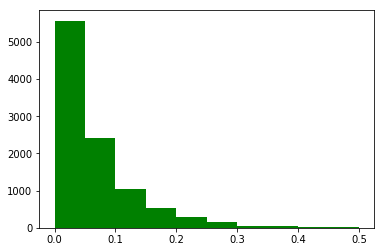

In [5]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics         import mean_squared_error, mean_absolute_error, median_absolute_error

from sklearn.ensemble        import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

FEATURES = list( dataFrame.columns ); FEATURES.remove('price')
COLUMNS  = list( dataFrame.columns );
LABEL    = "price";

Y_dataFrame = dataFrame    [['price']];        Y_values = Y_dataFrame.values;
X_dataFrame = dataFrame.drop('price', axis=1); X_values = X_dataFrame.values;

X_train, X_test, Y_train, Y_test = train_test_split( X_values, Y_values, test_size=0.2 )

estimator  = RandomForestRegressor()
param_grid = {'n_estimators':(8,12,16,20,24), 'oob_score':(True,False),'max_features':(2,3,4,5),'random_state':(1,) }

clf = GridSearchCV( estimator, param_grid )
clf.fit( X_train, Y_train ); print( clf.best_params_ )
Y_predict = clf.predict( X_test )

print( np.sqrt( mean_squared_error   ( Y_test[:,0], Y_predict ) ) )
print( mean_absolute_error  ( Y_test[:,0], Y_predict ) )
print( median_absolute_error( Y_test[:,0], Y_predict ) )

#print( Y_test[:,0] )
#print( Y_predict    )

Y_predict = np.array( Y_predict )
Y_test    = np.array( Y_test    ).squeeze()

Y_result = np.abs( Y_predict - Y_test )/Y_test

plt.hist( Y_result, bins=[0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50], facecolor='g')

bad_s  = len( Y_result[Y_result  > 0.05 ] )
good_s = len( Y_result[Y_result <= 0.05 ] )
print("good = {}, bad = {}, err = {}".format(good_s,bad_s, good_s/(good_s+bad_s)) )

bad_s  = len( Y_result[Y_result  > 0.1 ] )
good_s = len( Y_result[Y_result <= 0.1 ] )
print("good = {}, bad = {}, err = {}".format(good_s,bad_s, good_s/(good_s+bad_s)) )
"""
print( Y_train )
print( Y_test  )
print( Y_predict )

print( mean_squared_error ( Y_test[:,0], Y_predict ) )
print( mean_absolute_error( Y_test[:,0], Y_predict ) )
"""
"""
# Train set
Y_trainingDataFrame = pd.DataFrame( Y_train, columns = [LABEL])
trainingDataFrame = pd.DataFrame(X_train, columns = FEATURES).merge(Y_trainingDataFrame, left_index = True, right_index = True)
trainingDataFrame.head(10)
# Test set
Y_testingDataFrame = pd.DataFrame( Y_test, columns = [LABEL])
testingDataFrame  = pd.DataFrame(X_test, columns = FEATURES).merge(Y_testingDataFrame, left_index = True, right_index = True)
testingDataFrame.head(10)
"""

Выполняем нормализацию тренировочных и тестовых данных

In [6]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler

FEATURES = list( trainingDataFrame.columns ); FEATURES.remove('price')
COLUMNS  = list( trainingDataFrame.columns );
LABEL    = "price";

X_trainingData = trainingDataFrame.drop('price', axis=1); X_trainingValues = X_trainingData.values;
X_testingData  = testingDataFrame .drop('price', axis=1); X_testingValues  = X_testingData .values;

preprocess_x = MinMaxScaler(); preprocess_x.fit( X_trainingValues )

X_normalizedTrainingValues = preprocess_x.transform( X_trainingValues )
X_normalizedTestingValues  = preprocess_x.transform( X_testingValues  )

normalizedTrainingDataFrame = pd.DataFrame( X_normalizedTrainingValues,columns = FEATURES )
normalizedTestingDataFrame  = pd.DataFrame( X_normalizedTestingValues ,columns = FEATURES )


NameError: name 'trainingDataFrame' is not defined

Обучаем регрессионную модель ( RandomForest )

In [ ]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble    import RandomForestRegressor
from sklearn.metrics     import mean_squared_error, mean_absolute_error

X_trainingData = trainingDataFrame.drop('price', axis=1); X_trainingValues = X_trainingData.values
X_testingData  = testingDataFrame .drop('price', axis=1); X_testingValues  = X_testingData .values

estimator  = RandomForestRegressor()
param_grid = {'oob_score':(True,False),'max_features':(2,3,4,5),'random_state':(1,) }

#clf = GridSearchCV( estimator, param_grid )
#clf.fit( X_trainingValues, Y_train )
model =  RandomForestRegressor(n_estimators=10, oob_score=True, random_state=1);
model.fit(X_trainingValues, Y_train[:,0] )
Y_predictedValues = model.predict( X_testingValues ) # предсказание

#print( clf.best_params_ )

#Y_predictedValues = clf.predict( X_testingValues )

print( Y_train[:,0].shape )
print( Y_test [:,0].shape )

print( mean_squared_error ( Y_test[:,0], Y_predictedValues ) )
print( mean_absolute_error( Y_test[:,0], Y_predictedValues ) )

#y_predict_  = np.array( y_predict )
#y_test_     = np.array( y_test    ).squeeze()

#plt.hist( np.abs( y_predict_ - y_test_ )/y_test_, bins=[0.0,0.1,0.2,0.3,0.4,0.5], facecolor='g')